# Influence function estimation at Univerity of Iowa
xchong@lbl.gov, 18th July 2024
awojdyla@lbl.gov

The influence function changes today so we re-collect the data.

In [1]:
# load the influence funtion from file
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt  
import math


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 1 extract the influence function from the npy files

In [2]:
#load the data
ifs_file_name = "./new_ifs_onecell/seg3A_cells_1-24_postPole_ifs.npy"
influence_waves_3D_pV = np.load(ifs_file_name)
influence_waves_3D_pV = influence_waves_3D_pV[:16]

voltMaps_filename = "./onecell/seg3A_cells_1-16_voltMaps.npy"
voltMaps_V = np.load(voltMaps_filename)
print(influence_waves_3D_pV.shape,voltMaps_V.shape)

(16, 354, 1663) (16, 16)


Text(0, 0.5, 'k-th measurement')

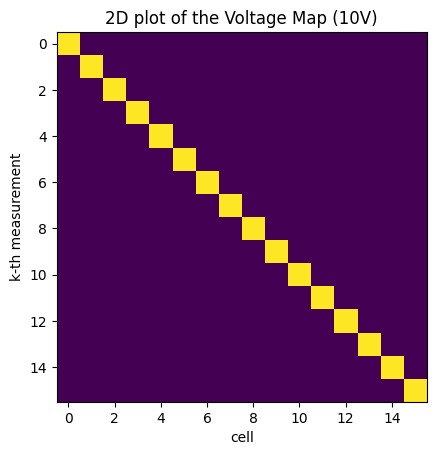

In [3]:
plt.imshow(voltMaps_V)
plt.title("2D plot of the Voltage Map (10V)")
plt.xlabel("cell")
plt.ylabel("k-th measurement")

Text(0, 0.5, 'y-axis position (mm)')

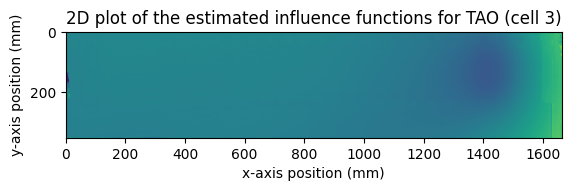

In [4]:
#2D plot of cell 3
plt.imshow(influence_waves_3D_pV[2,:,:])
plt.title("2D plot of the estimated influence functions for TAO (cell 3)")
plt.xlabel("x-axis position (mm)")
plt.ylabel("y-axis position (mm)")

Text(0, 0.5, '(um/10V)')

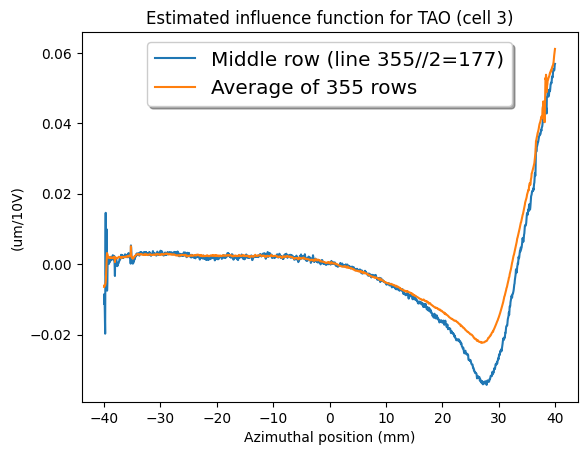

In [5]:
#1D plot of cell 3
fig,ax = plt.subplots()
cell_num = 2
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
yaxis = influence_waves_3D_pV[cell_num,177,:]
yaxis_avg = np.mean(influence_waves_3D_pV[cell_num,:,:], axis = 0)

plt.plot(xaxis,yaxis,label='Middle row (line 355//2=177)')
plt.plot(xaxis,yaxis_avg,label='Average of 355 rows')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')


plt.title("Estimated influence function for TAO (cell 3)")
ax.set_xlabel("Azimuthal position (mm)")
ax.set_ylabel("(um/10V)")

Text(0, 0.5, '(um/10V)')

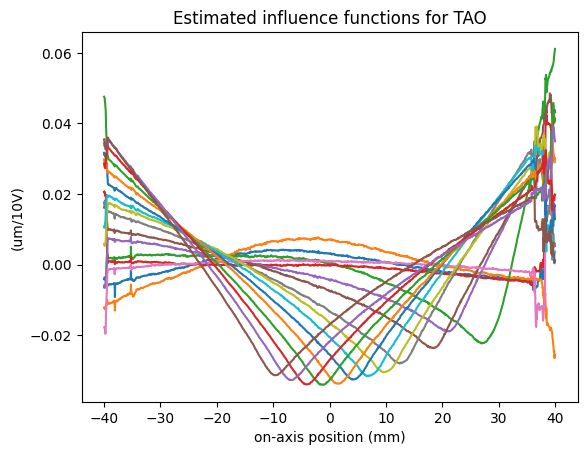

In [6]:
# plot the raw data, which contains artifcats due to the rectangular
fig,ax = plt.subplots()
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
for i in range(influence_waves_3D_pV.shape[0]):
    #calculate the average of the all rows     
    each_yaxis_avg = np.mean(influence_waves_3D_pV[i,:,:], axis = 0)
    plt.plot(xaxis,each_yaxis_avg)

plt.title("Estimated influence functions for TAO")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/10V)")

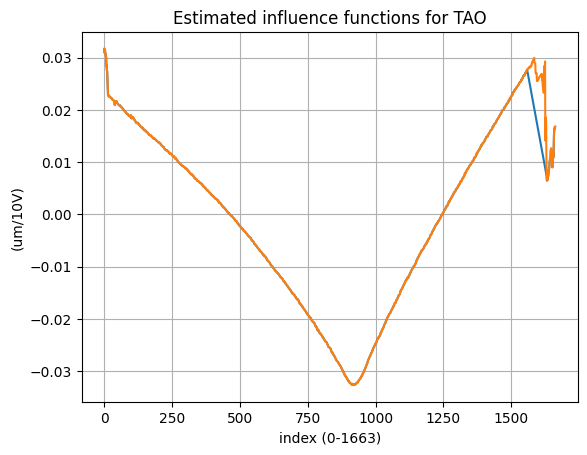

In [10]:
# interpolate the data to remove the artifacts
each_yaxis_avg = np.mean(influence_waves_3D_pV[10,:,:], axis = 0)
data_cleaned = each_yaxis_avg
idx = np.arange(len(each_yaxis_avg))
mask =  (idx<1560) | (idx>1630)
data_cleaned=np.interp(idx,idx[mask],each_yaxis_avg[mask])

plt.plot(data_cleaned)
plt.plot(each_yaxis_avg)
plt.xlabel("index (0-1663)")
plt.ylabel("(um/10V)")
plt.title("Estimated influence functions for TAO")  
plt.grid()
plt.show()

Text(0, 0.5, '(um/10V)')

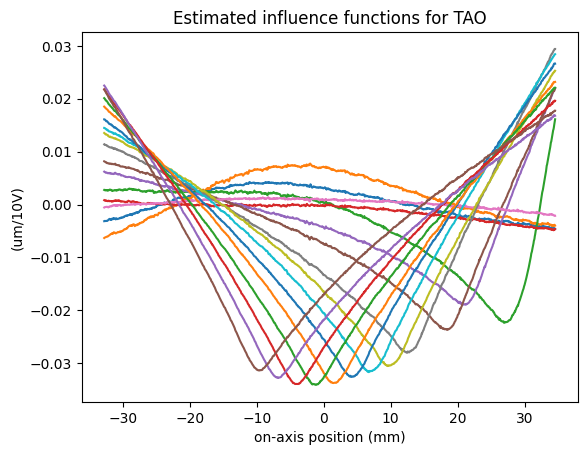

In [11]:
fig,ax = plt.subplots()
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
interp_start = 1560
interp_end = 1630

crop_start = 150
crop_end = 1550
influence_waves_pV=[]
for i in range(influence_waves_3D_pV.shape[0]):
    #calculate the average of the all rows     
    each_yaxis_avg_um = np.mean(influence_waves_3D_pV[i,:,:], axis = 0)

    # interpolate the values between the start and end
    idx = np.arange(len(each_yaxis_avg_um))
    mask =  (idx<interp_start) | (idx>interp_end)
    data_cleaned_um = np.interp(idx,idx[mask],each_yaxis_avg_um[mask])

    #remove the leftmost and rightmost points
    influence_waves_pV.append(data_cleaned_um[crop_start:crop_end])
    plt.plot(xaxis[crop_start:crop_end],data_cleaned_um[crop_start:crop_end])
influence_waves_umpV = np.array(influence_waves_pV).transpose((1,0))/10
plt.title("Estimated influence functions for TAO")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/10V)")

# 2 find input voltage for a target wavefront

(1400, 18)


Text(0, 0.5, '(um/1V)')

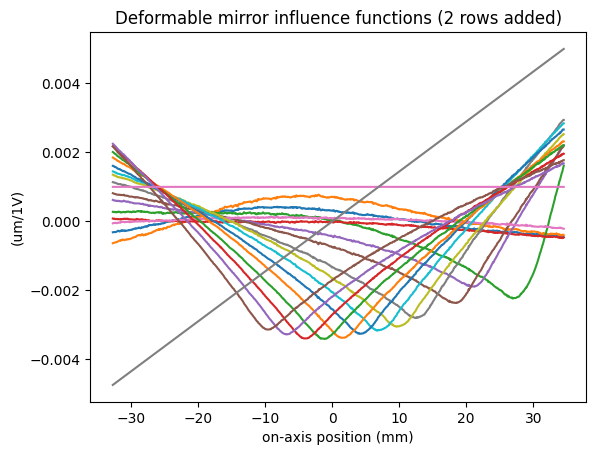

In [12]:
# add two rows to the influence function
y_mm = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
y_mm = y_mm[crop_start:crop_end]
y_mm = np.expand_dims(y_mm, axis=1)


a,b = np.shape(influence_waves_umpV)
row1 = np.zeros((a,1))+0.001
row2 = y_mm/np.max(y_mm)*0.005


influence_waves_extend_umpV = np.concatenate((influence_waves_umpV,row1),axis=1)
influence_waves_extend_umpV = np.concatenate((influence_waves_extend_umpV,row2),axis=1)

np.save("seg3A_cells_1-18_ifs", influence_waves_extend_umpV)
print(influence_waves_extend_umpV.shape)

plt.plot(y_mm, influence_waves_extend_umpV)
plt.title("Deformable mirror influence functions (2 rows added)")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/1V)")

Text(0, 0.5, 'Wavefront (nm)')

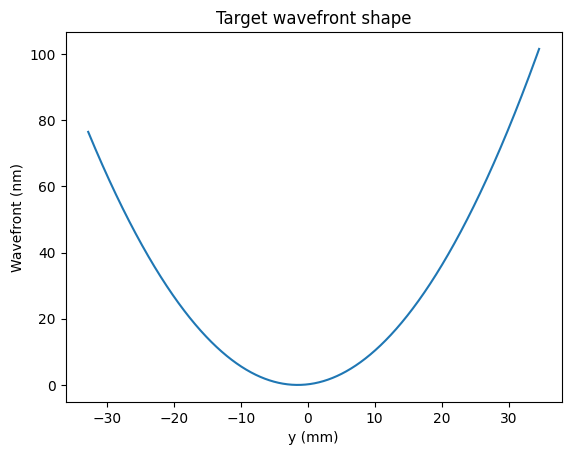

In [13]:
#define a target wavefront shape
target_shape_m = (((idx-800)/np.max(idx))**2)*100e-9*5
wavefront_w = target_shape_m[crop_start:crop_end]

plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

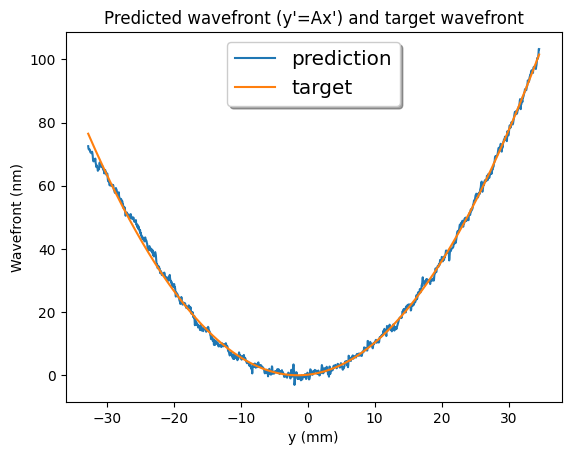

In [14]:
# find the solution by using Ax = y, x = A^-1 * y 
solution_V = np.dot(np.linalg.pinv(influence_waves_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

solution_V [-5.90637156e-05 -3.29099613e-06  1.05164275e-06  3.28162435e-05
  4.11952649e-06  5.15509046e-07 -7.90280540e-05  3.06363341e-06
 -3.00818347e-07  1.07255789e-06  1.92683289e-06  4.66443960e-08
  1.82160382e-06 -6.77235408e-07 -6.64947202e-07 -1.69206859e-06
  4.11517927e-05  9.52653048e-07]


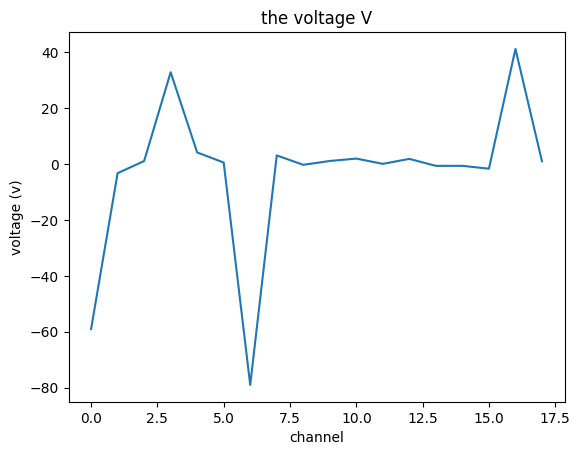

In [15]:
# plot the solution voltage
print("solution_V",solution_V)

plt.plot(solution_V[:18]*1e6)
plt.title("the voltage V")
plt.xlabel("channel")
plt.ylabel("voltage (v)")
plt.show()

Text(0, 0.5, 'Wavefront nm)')

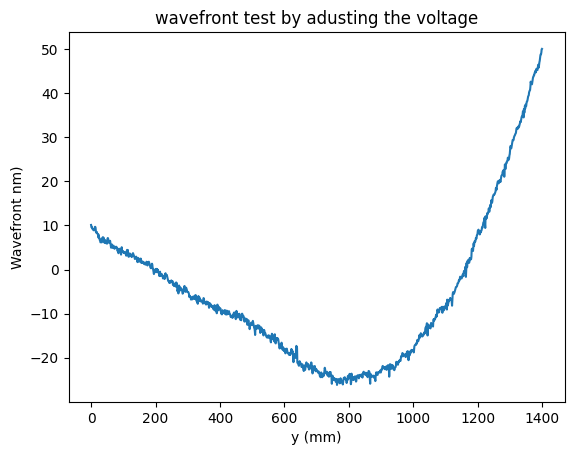

In [16]:
solution_V2 = np.copy(solution_V)
solution_V2[0] = 0 #--> is not connected, null influence function
solution_V2[3] = 0
solution_V2[16] = 0 #--> pure tilt term
#plt.plot(np.dot(h,solution_V2))
solution_nm = np.dot(influence_waves_extend_umpV,solution_V)*1e9
plt.plot(np.dot(influence_waves_extend_umpV,solution_V2)*1e9)
plt.title("wavefront test by adusting the voltage")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront nm)")
#plt.plot(solution_V*1e6)

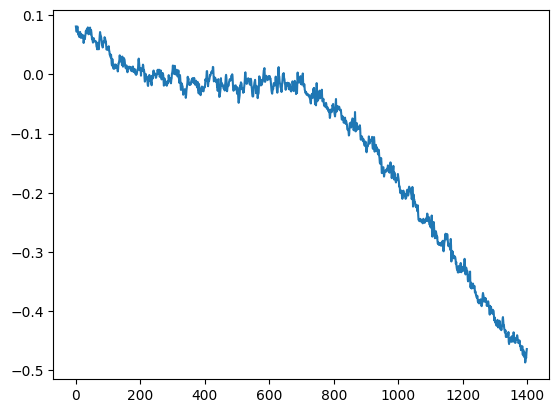

In [17]:
plt.plot(influence_waves_extend_umpV[:,3]*1e3)   

(1400, 12)


Text(0, 0.5, '(um/10V)')

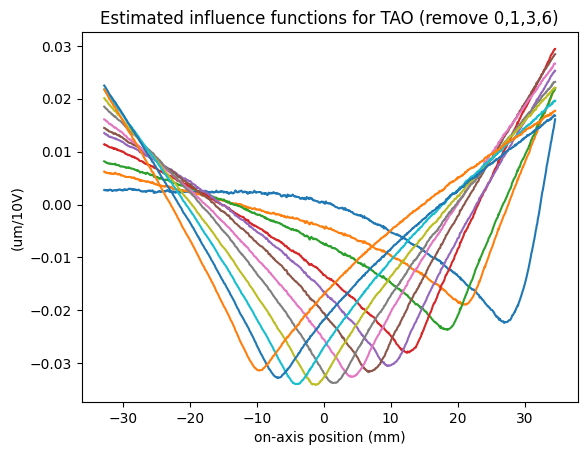

In [37]:
# remove index= 0,1, and 3
fig,ax = plt.subplots()
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
interp_start = 1560
interp_end = 1630

crop_start = 150
crop_end = 1550
influence_waves_cleaned_pV=[]
for i in range(influence_waves_3D_pV.shape[0]):
    if i==0 or i==1 or i==3 or i ==6:                             
        continue
    #calculate the average of the all rows     
    each_yaxis_avg_um = np.mean(influence_waves_3D_pV[i,:,:], axis = 0)

    # interpolate the values between the start and end
    idx = np.arange(len(each_yaxis_avg_um))
    mask =  (idx<interp_start) | (idx>interp_end)
    data_cleaned_um = np.interp(idx,idx[mask],each_yaxis_avg_um[mask])

    #remove the leftmost and rightmost points
    influence_waves_cleaned_pV.append(data_cleaned_um[crop_start:crop_end])
    plt.plot(xaxis[crop_start:crop_end],data_cleaned_um[crop_start:crop_end])

influence_waves_cleaned_umpV = np.array(influence_waves_cleaned_pV).transpose((1,0))/10
print(influence_waves_cleaned_umpV.shape)
plt.title("Estimated influence functions for TAO (remove 0,1,3,6)")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/10V)")

Text(0, 0.5, '(um/1V)')

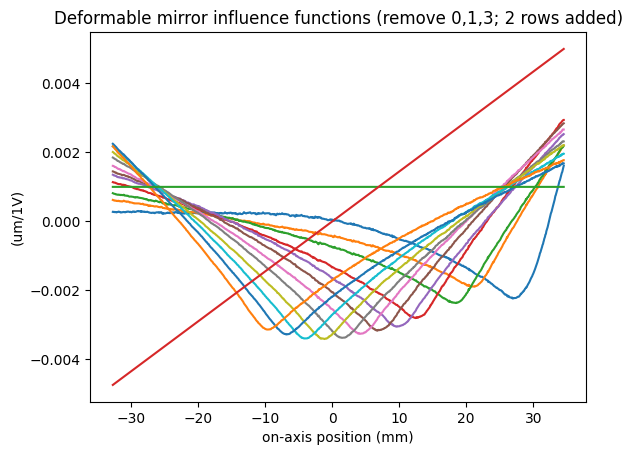

In [38]:
c,d = np.shape(influence_waves_cleaned_umpV)
row3 = np.zeros((c,1))+0.001
row4 = y_mm/np.max(y_mm)*0.005


influence_waves_cleaned_extend_umpV = np.concatenate((influence_waves_cleaned_umpV,row3),axis=1)
influence_waves_cleaned_extend_umpV = np.concatenate((influence_waves_cleaned_extend_umpV,row4),axis=1)

plt.plot(y_mm, influence_waves_cleaned_extend_umpV)
plt.title("Deformable mirror influence functions (remove 0,1,3; 2 rows added)")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/1V)")

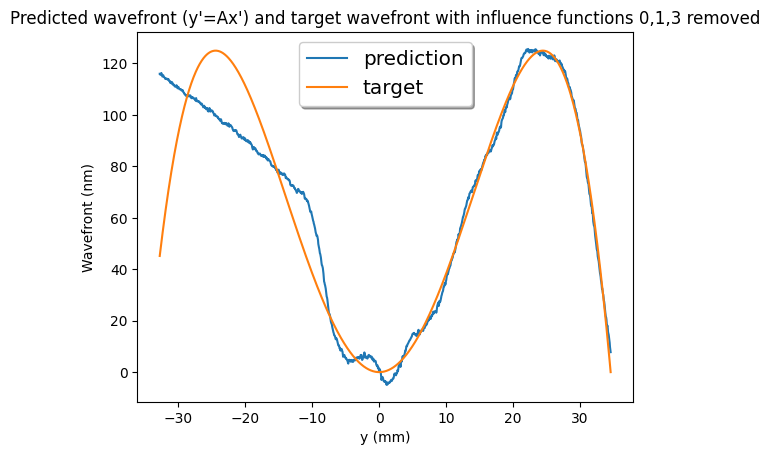

In [39]:
solution_V = np.dot(np.linalg.pinv(influence_waves_cleaned_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_cleaned_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave_m.npy",solution_w)

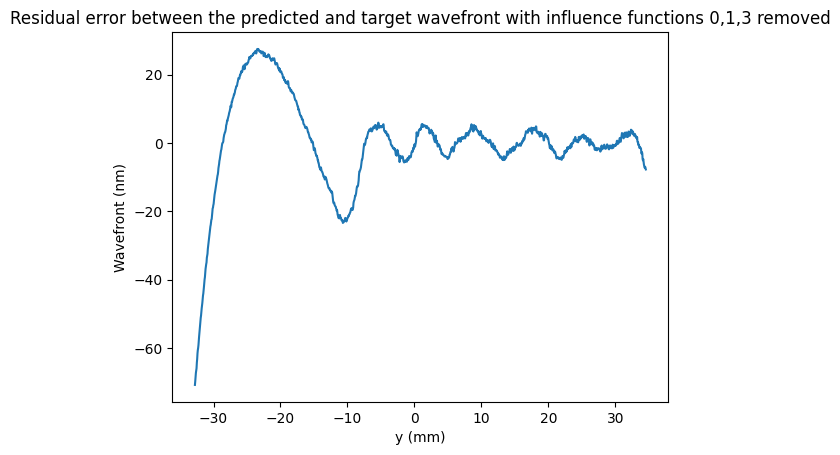

In [40]:
plt.plot(y_mm, (wavefront_w-solution_w)*1e9)
plt.title("Residual error between the predicted and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

In [41]:
rms_nm = np.std((wavefront_w-solution_w)*1e9)
print("rms error (nm)",rms_nm)

rms error (nm) 13.799325345591228


In [47]:
print(solution_V*1e6)

solution_18 = np.insert(solution_V,0,np.nan)
solution_18 = np.insert(solution_18,0,np.nan)
solution_18 = np.insert(solution_18,3,np.nan)
solution_18 = np.insert(solution_18,6,np.nan)

np.save("seg3A_cells_1-18_volts.npy", solution_18)
print(solution_18.shape)
print(solution_18)

[[-21.90508443]
 [-24.86112744]
 [  7.46393596]
 [-11.17321075]
 [  9.14678951]
 [ 11.37255913]
 [-15.85428623]
 [ 31.44138045]
 [-17.70108612]
 [ 12.71865396]
 [ 32.40507257]
 [-33.60823323]
 [ 69.68301884]
 [ -4.41705184]]
(18,)
[            nan             nan -2.19050844e-05             nan
 -2.48611274e-05  7.46393596e-06             nan -1.11732108e-05
  9.14678951e-06  1.13725591e-05 -1.58542862e-05  3.14413805e-05
 -1.77010861e-05  1.27186540e-05  3.24050726e-05 -3.36082332e-05
  6.96830188e-05 -4.41705184e-06]


[            nan             nan -2.19050844e-05             nan
 -2.48611274e-05  7.46393596e-06             nan -1.11732108e-05
  9.14678951e-06  1.13725591e-05 -1.58542862e-05  3.14413805e-05
 -1.77010861e-05  1.27186540e-05  3.24050726e-05 -3.36082332e-05
  6.96830188e-05 -4.41705184e-06]


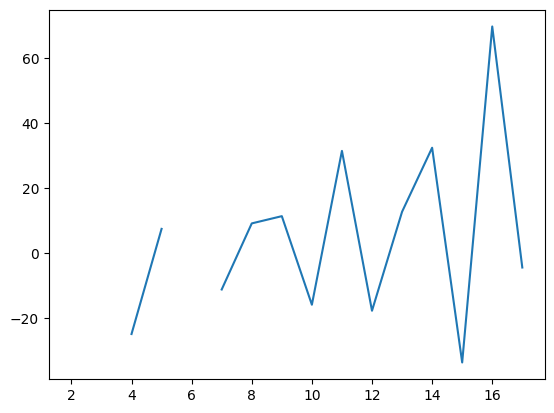

In [54]:
ifs = np.load("seg3A_cells_1-18_ifs.npy")
volts=np.load("seg3A_cells_1-18_volts.npy")
wavefront_w=np.load("seg3A_cells_1-18_predictwave_m.npy")
print(volts)
plt.plot(volts*1e6)
# print(ifs.shape)
# plt.plot(y_mm, wavefront_w)

Text(0, 0.5, 'Wavefront (nm)')

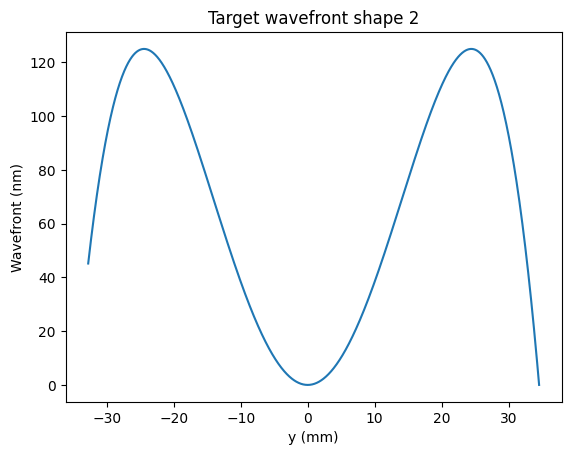

In [26]:
#define a target wavefront shape
target_shape_m = (((idx-800)/np.max(idx))**2)*100e-9*5


###
yc_mm = 10
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2)*100e-9*5
wavefront_w = target_shape_m
###

yc_mm = 0
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2-((y_mm-yc_mm)/np.max(y_mm))**4)*100e-9*5
wavefront_w = target_shape_m


plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape 2")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

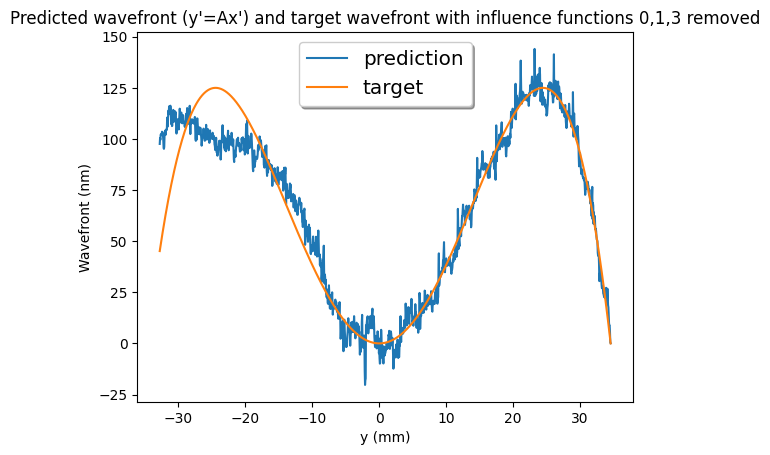

In [27]:
solution_V = np.dot(np.linalg.pinv(influence_waves_cleaned_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_cleaned_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave2_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave2_m.npy",solution_w)

In [28]:
print(solution_V*1e6)

solution_18 = np.insert(solution_V,0,np.nan)
solution_18 = np.insert(solution_18,0,np.nan)
solution_18 = np.insert(solution_18,3,np.nan)

np.save("seg3A_cells_1-18_volts2.npy", solution_18)
print(solution_18)

[[-19.21007725]
 [-20.24667666]
 [  6.42301847]
 [610.73785674]
 [ -6.40381317]
 [ 17.39363011]
 [  3.35687724]
 [ -6.47102183]
 [ 28.20821013]
 [-15.04832653]
 [ 17.51335554]
 [ 20.05784106]
 [ -8.75888794]
 [ 68.44091815]
 [  4.38492049]]
[            nan             nan -1.92100773e-05             nan
 -2.02466767e-05  6.42301847e-06  6.10737857e-04 -6.40381317e-06
  1.73936301e-05  3.35687724e-06 -6.47102183e-06  2.82082101e-05
 -1.50483265e-05  1.75133555e-05  2.00578411e-05 -8.75888794e-06
  6.84409182e-05  4.38492049e-06]


[            nan             nan -1.92100773e-05             nan
 -2.02466767e-05  6.42301847e-06  6.10737857e-04 -6.40381317e-06
  1.73936301e-05  3.35687724e-06 -6.47102183e-06  2.82082101e-05
 -1.50483265e-05  1.75133555e-05  2.00578411e-05 -8.75888794e-06
  6.84409182e-05  4.38492049e-06]


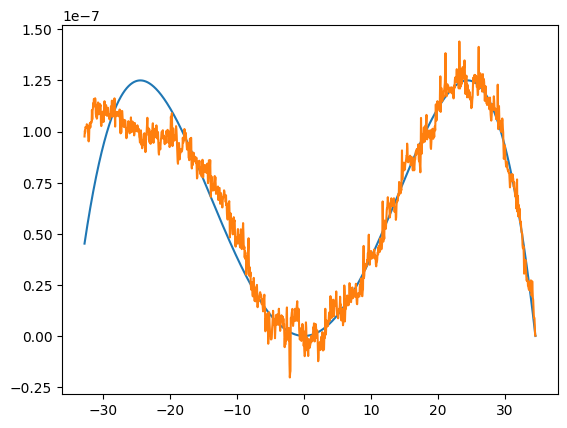

In [29]:

volts=np.load("seg3A_cells_1-18_volts2.npy")
target=np.load("seg3A_cells_1-18_targetwave2_m.npy")
pre=np.load("seg3A_cells_1-18_predictwave2_m.npy")
print(volts)
plt.plot(y_mm, target)
plt.plot(y_mm, pre)


Text(0, 0.5, 'Wavefront (nm)')

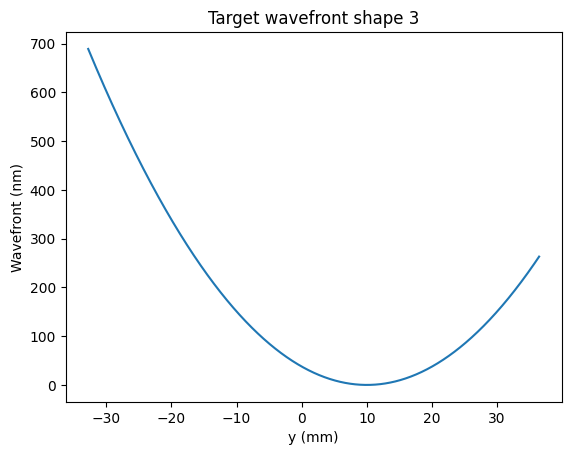

In [31]:
#define a target wavefront shape
target_shape_m = (((idx-800)/np.max(idx))**2)*100e-9*5


###
yc_mm = 10
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2)*100e-9*5
wavefront_w = target_shape_m
###




plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape 3")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

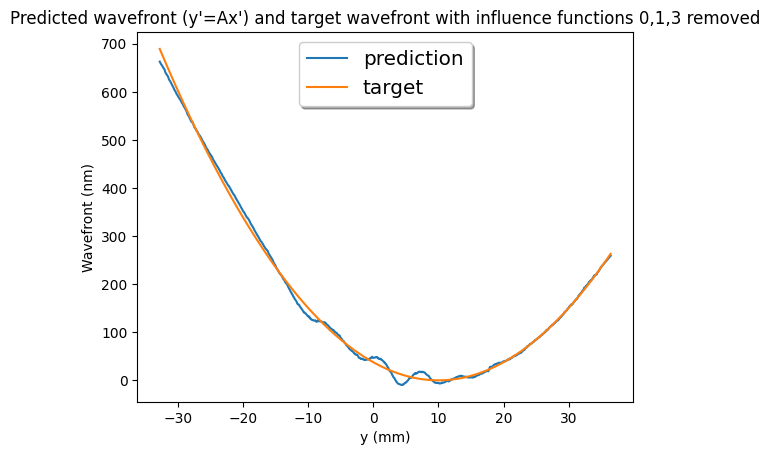

In [32]:
solution_V = np.dot(np.linalg.pinv(influence_waves_cleaned_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_cleaned_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave3_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave3_m.npy",solution_w)

In [33]:
print(solution_V*1e6)

solution_18 = np.insert(solution_V,0,np.nan)
solution_18 = np.insert(solution_18,0,np.nan)
solution_18 = np.insert(solution_18,3,np.nan)

np.save("seg3A_cells_1-18_volts3.npy", solution_18)
print(solution_18)

[[  8.3653967 ]
 [ 16.83236345]
 [-13.77893228]
 [ 32.48123814]
 [-28.29875723]
 [ 62.10954574]
 [-83.67463944]
 [112.34522154]
 [-81.26877622]
 [ 52.85421579]
 [  0.70430915]
 [-25.96264231]
 [ 51.27513837]
 [232.33561288]
 [-52.16432515]]
[            nan             nan  8.36539670e-06             nan
  1.68323635e-05 -1.37789323e-05  3.24812381e-05 -2.82987572e-05
  6.21095457e-05 -8.36746394e-05  1.12345222e-04 -8.12687762e-05
  5.28542158e-05  7.04309151e-07 -2.59626423e-05  5.12751384e-05
  2.32335613e-04 -5.21643252e-05]


[            nan             nan  8.36539670e-06             nan
  1.68323635e-05 -1.37789323e-05  3.24812381e-05 -2.82987572e-05
  6.21095457e-05 -8.36746394e-05  1.12345222e-04 -8.12687762e-05
  5.28542158e-05  7.04309151e-07 -2.59626423e-05  5.12751384e-05
  2.32335613e-04 -5.21643252e-05]


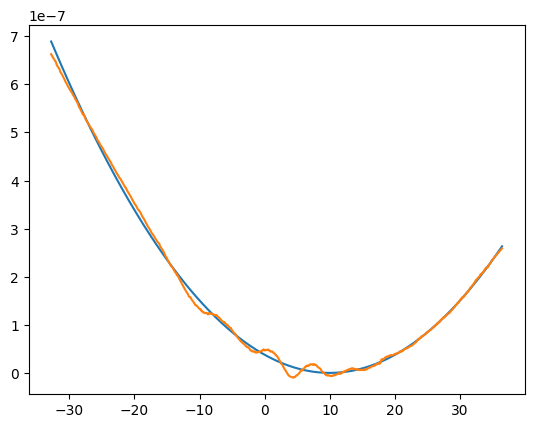

In [40]:

volts=np.load("seg3A_cells_1-18_volts3.npy")
target=np.load("seg3A_cells_1-18_targetwave3_m.npy")
pre=np.load("seg3A_cells_1-18_predictwave3_m.npy")
print(volts)
plt.plot(y_mm, target)
plt.plot(y_mm, pre)

# 3 compare with the influence function collected at argone nation lab

Text(0.5, 0, 'on-axis position (mm)')

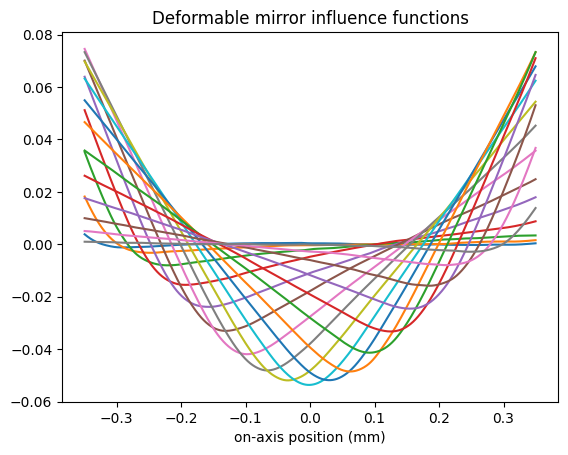

In [28]:
# change here!
file_name = "../task7_monoplus_4th/axo_jtec_aps_influence.mat"

# load the data
data = sc.loadmat(file_name)

#Extracting data from the file
datay_m = data["y_m"]
datainfluence_waves_pV = data["infFn_w"]

#Removing the nan data
noNAN = np.isfinite(datainfluence_waves_pV)
rinfluence_waves_pV = np.array(datainfluence_waves_pV[noNAN])

#Reshaping the array
influence_waves_pV2 = np.reshape(rinfluence_waves_pV, (1077, 18)) 

y_m2 = datay_m[742:1819]

plt.plot(y_m2*1e3, influence_waves_pV2[:,:])
plt.title("Deformable mirror influence functions")
plt.xlabel("on-axis position (mm)")